In [83]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sympy.solvers import solve
from sympy import Symbol
import scipy.stats as sstats

from utils import SimulateData
from stopsignalmetrics import SSRTmodel, StopData

from scipy.stats import exponnorm, norm, norminvgauss
from scipy import stats

from generate_remaining_sim_cmds import replace

# __Preprocessing__

## 1. Prepare data for use by stopsignalmetrics

In [2]:
abcd_data = pd.read_csv('abcd_data/abcd_w_finger_press.csv')

In [3]:
len(abcd_data.NARGUID.unique())

8464

In [4]:
for rt_col in ['go_rt_adjusted', 'stop_rt_adjusted']:
    abcd_data.loc[abcd_data['finger_press'].isnull(), rt_col] = np.nan

In [5]:
abcd_data['block'] = np.NaN
abcd_data.loc[abcd_data['TrialNum'] < 180, 'block'] = '1'
abcd_data.loc[abcd_data['TrialNum'] >= 180, 'block'] = '2'

In [6]:
abcd_data['choice_accuracy'] = np.where(
    abcd_data['finger_press'].notnull(),
    np.where(
        abcd_data['finger_press']==abcd_data['correct_response'],
        1,
        0),
    np.nan
)

In [7]:
len(abcd_data.NARGUID.unique())

8464

## 1.5 replace IDs with ` (backticks) in them
#### shell scripts do not interpret them well

In [8]:
def strip_backticks(string):
    return string.replace('`', '')

In [9]:
original_unique_IDs = abcd_data.NARGUID.unique()
fix_id_map = {i:strip_backticks(i) for i in abcd_data.NARGUID.unique() if '`' in i}
abcd_data.NARGUID = abcd_data.NARGUID.replace(fix_id_map)
assert len(original_unique_IDs)==len(abcd_data.NARGUID.unique())

In [10]:
abcd_data.to_csv('abcd_data/minimal_abcd_with_issue_3.csv', index=False)

## 2. Drop Issue 3 people

In [11]:
abcd_data_w_issue_3 = pd.read_csv('abcd_data/minimal_abcd_with_issue_3.csv')

In [12]:
abcd_data_w_issue_3['correct_go_response'].unique()

array([ 1.,  0., nan])

In [13]:
issue_3_people = abcd_data_w_issue_3.loc[(abcd_data_w_issue_3['stop_rt_adjusted'] < 50) & (abcd_data_w_issue_3['stop_rt_adjusted'] > 0) & (abcd_data_w_issue_3['SSDDur'] ==50), 'NARGUID'].unique()

print('n affected:', len(issue_3_people))
print('p affect:', len(issue_3_people)/ 7231)

abcd_data = abcd_data_w_issue_3[~abcd_data_w_issue_3.NARGUID.isin(issue_3_people)].copy()
print('n remaining:', abcd_data.NARGUID.nunique())

n affected: 226
p affect: 0.03125432167058498
n remaining: 8238


In [14]:
abcd_data.to_csv('abcd_data/minimal_abcd_clean.csv', index=False)

# __Metrics for Simulation__

In [2]:
abcd_data = pd.read_csv('abcd_data/minimal_abcd_clean.csv')

## 1. Find mu_go and mu_stop for each individual using their mean Go RT and their SSRT

In [3]:
variable_dict = {
   "columns": {
      "ID": "NARGUID", #subject identifier
      "condition": "trial_type", #col with trial types 
      "correct_response": "correct_response", #col with correct reponse codes
      "response": "finger_press", #col with actual response codes 
      "SSD": "SSDDur", #col with stop signal delay 
      "block": "block", #col with which block a trial is accuring during
      "goRT": "go_rt_adjusted", # col with go reaction time recording 
      "stopRT": "stop_rt_adjusted", #col with stop failure reaction time recording
      "choice_accuracy": "choice_accuracy" #col with whether a response was correct
   },
   "key_codes": {
      "go": "GoTrial", # cell values for go trials  
      "stop": "StopTrial",  #cell values for stop trials 
      "correct": 1.0,
       "incorrect": 0.0,
       "noResponse": np.nan
   }
}

In [4]:
abcd_ssrt = StopData(var_dict=variable_dict, compute_acc_col=False)

abcd_proc = abcd_ssrt.fit_transform(abcd_data) 

ssrt_model = SSRTmodel(model='replacement')

ssrt_metrics = ssrt_model.fit_transform(abcd_proc, level='group')

problem_subs = ssrt_metrics[ssrt_metrics.SSRT.isnull()].index

print(f'dropping {len(problem_subs)} subs for having P(respond|signal) == 1 or 0')

ssrt_metrics = ssrt_metrics[ssrt_metrics.SSRT.notnull()].copy()

/Users/henrymj/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/henrymj/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


dropping 31 subs for having P(respond|signal) == 1 or 0


In [5]:
ssrt_metrics.to_csv('abcd_data/abcd_ssrt_metrics.csv')

In [6]:
rt_std = abcd_proc.groupby('ID').apply(lambda x: x.describe().loc[['mean', 'std'], 'goRT'])
rt_std

goRT,mean,std
ID,,
003RTV85,634.652632,169.271353
007W6H7B,653.491582,178.164613
00CY2MDM,467.901408,200.308095
00HEV6HB,450.200692,228.866837
00J52GPG,405.978648,157.648749
...,...,...
vcahyykd,NaN,NaN
ve4u5,451.784452,132.458823
wzrf2ge6,591.981818,186.033696


In [7]:
def get_mus(sub_row):
    sub_row = sub_row.copy()
    mu_dict = {}
    # init go and stop vars
    g = Symbol('g')
    s = Symbol('s')
    
    # formulas (must be solved as "expression = 0")
    # subject_{go/ss}rt = threshold/mu_go + nondecision_time
    # threshold = 100
    # nondecision_time = 50
    
    go_sol = solve((sub_row['mean_go_RT'].values[0] - 50) * g - 100, g)
#     go_sol = solve(100/g + 50 - sub_row['mean_go_RT'].values[0], g)
    assert len(go_sol) == 1, f"{len(go_sol)} solutions found based on {sub_row['mean_go_RT']}: {go_sol}"
    mu_dict['go'] = float(go_sol[0])
    
    stop_sol = solve(100/s + 50 - sub_row['SSRT'].values[0], s)
    assert len(stop_sol) == 1, f"{len(stop_sol)} solutions found based on {sub_row['SSRT']}: {stop_sol}"
    mu_dict['stop'] = float(stop_sol[0])
    
    return mu_dict

mu_df = ssrt_metrics.groupby('ID').apply(get_mus)
mu_dict = mu_df.to_dict()
mu_dict['prob_subs'] = list(problem_subs)
mu_df = mu_df.apply(pd.Series)

In [8]:
json_mu_path = 'abcd_data/individual_mus.json'
with open(json_mu_path, 'w') as jp:
    json.dump(mu_dict, jp)

In [15]:
mu_df.corr()

,go,stop
go,1.00000,-0.00661
stop,-0.00661,1.00000


In [27]:
len(mu_df)

8207

In [38]:
clipped_mu_df = mu_df.query("stop < 2.0 and stop >= 0")
len(clipped_mu_df)

8090

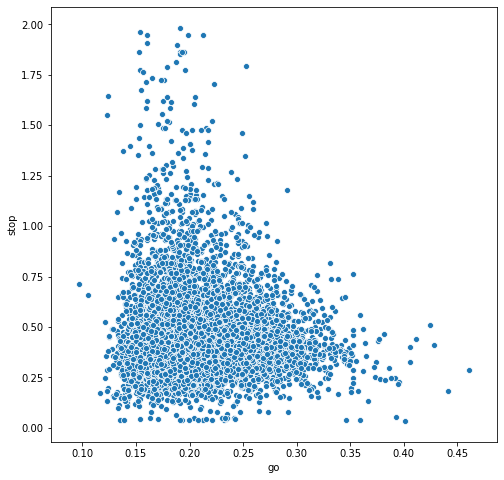

In [39]:
plt.figure(figsize=(8,8))
_ = sns.scatterplot(x='go', y='stop', data=clipped_mu_df)

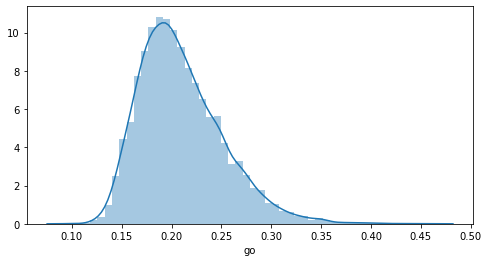

In [48]:
plt.figure(figsize=(8,4))
_ = sns.distplot(clipped_mu_df['go'])

In [51]:
subfit = exponnorm.fit(clipped_mu_df['go'])
ks = stats.kstest(clipped_mu_df['go'], "exponnorm", subfit)
print(subfit, ks)

(1.6145162392155137, 0.17263585095396383, 0.02287508115532174) KstestResult(statistic=0.021258528451471803, pvalue=0.0013347652620834204)


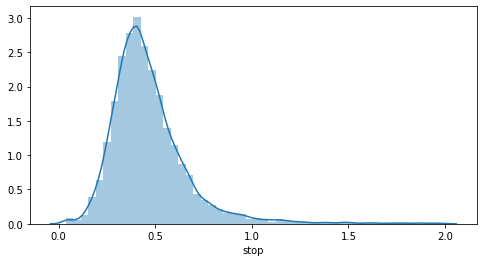

In [49]:
plt.figure(figsize=(8,4))
_ = sns.distplot(clipped_mu_df['stop'])

In [52]:
subfit = exponnorm.fit(clipped_mu_df['stop'])
ks = stats.kstest(clipped_mu_df['stop'], "exponnorm", subfit)
print(subfit, ks)

(1.8776287645148577, 0.29990967697958365, 0.08926995206606532) KstestResult(statistic=0.0201797247797586, pvalue=0.0027512681459233384)


(1.6463989499308598, 0.17213145634524582, 0.02264734856063249) KstestResult(statistic=0.020907234242656836, pvalue=0.0015313333225754765)


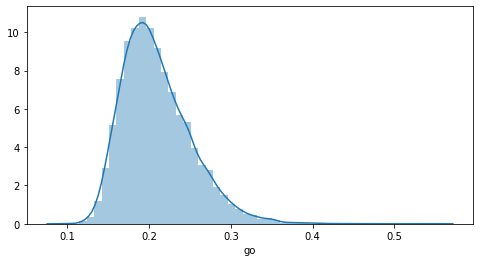

In [59]:
plt.figure(figsize=(8,4))
_ = sns.distplot(mu_df['go'])

subfit = exponnorm.fit(mu_df['go'])
ks = stats.kstest(mu_df['go'], "exponnorm", subfit)
print(subfit, ks)

/Users/henrymj/anaconda3/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:1535: RuntimeWarning: divide by zero encountered in log
  return exparg + np.log(0.5 * invK * sc.erfc(-(x - invK) / np.sqrt(2)))


(0.6078020640056576, 0.1651481083991087, 0.5417425921669012) KstestResult(statistic=0.2921204519705178, pvalue=0.0)


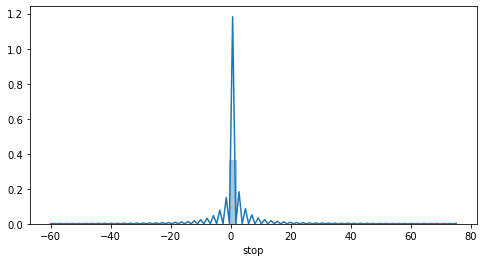

In [60]:
plt.figure(figsize=(8,4))
_ = sns.distplot(mu_df['stop'])

subfit = exponnorm.fit(mu_df['stop'])
ks = stats.kstest(mu_df['stop'], "exponnorm", subfit)
print(subfit, ks)

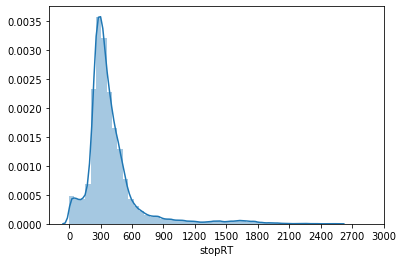

In [69]:
ax = sns.distplot(abcd_proc.loc[abcd_proc.SSD==0, 'stopRT'])
_ = ax.set_xticks(np.arange(0, 3200, 300))

In [72]:
ax = sns.distplot(abcd_proc.loc[abcd_proc.SSD==0, 'stopRT'])
_ = ax.set_xticks(np.arange(0, 3200, 300))

900.0

(301.33996168804316, 162.6700392464751) KstestResult(statistic=0.1667539651250305, pvalue=1.2005587726686401e-198)


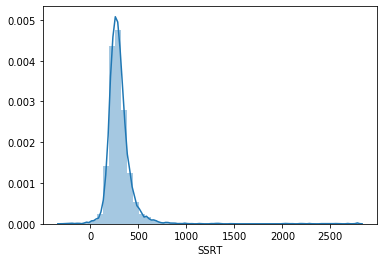

In [86]:
distfit = norm.fit(ssrt_metrics['SSRT'])
ks = stats.kstest(ssrt_metrics['SSRT'], "norm", distfit)
ax = sns.distplot(ssrt_metrics['SSRT'])
print(distfit, ks)

(545.7437815992497, 93.84023748232624) KstestResult(statistic=0.016602802606291378, pvalue=0.021678737713900293)


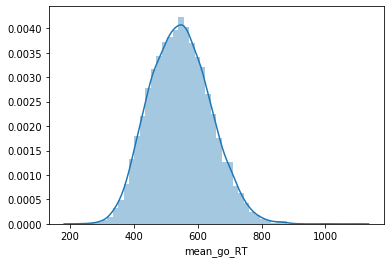

In [87]:
distfit = norm.fit(ssrt_metrics['mean_go_RT'])
ks = stats.kstest(ssrt_metrics['mean_go_RT'], "norm", distfit)
ax = sns.distplot(ssrt_metrics['mean_go_RT'])
print(distfit, ks)

In [80]:
ssrt_metrics

,SSRT,mean_SSD,p_respond,max_RT,mean_go_RT,mean_stopfail_RT,omission_count,omission_rate,go_acc,stopfail_acc
ID,,,,,,,,,,
003RTV85,273.000000,315.000000,0.466667,2793.0,634.652632,546.107143,15.0,0.050000,0.936842,0.821429
007W6H7B,166.666667,418.333333,0.433333,2793.0,653.491582,562.000000,3.0,0.010000,0.962963,0.923077
00CY2MDM,413.500000,72.500000,0.600000,2793.0,467.901408,347.583333,16.0,0.053333,0.852113,0.722222
00HEV6HB,321.666667,163.333333,0.633333,2793.0,450.200692,373.947368,11.0,0.036667,0.851211,0.657895
00J52GPG,394.666667,53.333333,0.600000,2793.0,405.978648,305.194444,19.0,0.063333,0.907473,0.500000
...,...,...,...,...,...,...,...,...,...,...
v49bv0fe,55.500000,557.500000,0.250000,2793.0,470.041667,458.866667,204.0,0.680000,0.781250,0.600000
ve4u5,233.666667,188.333333,0.450000,2793.0,451.784452,387.851852,17.0,0.056667,0.964664,0.851852
wzrf2ge6,237.000000,305.000000,0.450000,2793.0,591.981818,502.111111,25.0,0.083333,0.978182,0.925926


## 1. get SSD distributions per subject

In [19]:
abcd_data = pd.read_csv('abcd_data/minimal_abcd_clean.csv')

In [21]:
SSD_dist = abcd_data.groupby('NARGUID')['SSDDur'].value_counts(normalize=True)
SSD_dist.name = 'proportion'
SSD_dist = SSD_dist.reset_index()

In [22]:
SSD_dist.to_csv('abcd_data/SSD_dist_by_subj.csv', index=False)

## 2. P(guess|SSD) for mixture distributions

In [24]:
abcd_data = pd.read_csv('abcd_data/minimal_abcd_clean.csv')
SSDs = abcd_data.SSDDur.unique()
SSDs = [i for i in SSDs if i == i]
SSDs.sort()

In [25]:
acc_per_SSD = pd.DataFrame()
for ssd in SSDs:
    curr_means = abcd_data.query(
        "SSDDur == %s and correct_stop==0.0" % ssd
    ).groupby('NARGUID').mean()['choice_accuracy']
    curr_means.name = ssd
    acc_per_SSD = pd.concat([acc_per_SSD, curr_means], 1, sort=True)

go_accs = abcd_data.query(
        "trial_type == 'GoTrial' and correct_go_response in [1.0, 0.0]"
    ).groupby('NARGUID').mean()['choice_accuracy']
go_accs.name = -1
acc_per_SSD = pd.concat([acc_per_SSD, go_accs], 1, sort=True)

In [26]:
p = Symbol('p')
guess_mean = acc_per_SSD.mean()[0.0]
go_mean = acc_per_SSD.mean()[-1]
p_guess_per_SSD = {}
for ssd in SSDs:
    curr_mean = acc_per_SSD.mean()[ssd]
    solution = solve(p*guess_mean + (1-p)*go_mean - curr_mean, p)
    assert len(solution) == 1
    p_guess_per_SSD[ssd] = solution[0]
p_guess_df = pd.DataFrame(p_guess_per_SSD, index=['p_guess'])
p_guess_df.to_csv('abcd_data/p_guess_per_ssd.csv', index=False)

In [27]:
{col: float(p_guess_df[col].values[0]) for col
                      in p_guess_df.columns}

{0.0: 1.0,
 50.0: 0.8518966881510508,
 100.0: 0.6248081425758761,
 150.0: 0.46519470731379453,
 200.0: 0.2947710624963631,
 250.0: 0.21075535798552303,
 300.0: 0.1404209047269027,
 350.0: 0.08354920017624702,
 400.0: 0.05703409119007931,
 450.0: 0.029151024358994575,
 500.0: 0.016063618909064378,
 550.0: -0.0003910068585019575,
 600.0: 0.0030962512655911116,
 650.0: 0.01139533818314855,
 700.0: 0.059318925632538,
 750.0: 0.0340178091093458,
 800.0: 0.15944204679687593,
 850.0: 0.20942638758940402,
 900.0: 0.24241997384504005}

In [28]:
p_guess_df2 = pd.read_csv('abcd_data/p_guess_per_ssd.csv')

In [29]:
p_guess_df2

,0.0,50.0,100.0,150.0,200.0,250.0,300.0,350.0,400.0,450.0,500.0,550.0,600.0,650.0,700.0,750.0,800.0,850.0,900.0
0,1.0,0.851897,0.624808,0.465195,0.294771,0.210755,0.140421,0.083549,0.057034,0.029151,0.016064,-0.000391,0.003096,0.011395,0.059319,0.034018,0.159442,0.209426,0.24242


## 3. Inhibition function (p(respond|SSD))

In [30]:
def get_p_resp_per_SSD(data, SSDs):
    data = data.copy()
    out_dict = {}
    for ssd in SSDs:
        curr_data = data.query(
            "SSDDur == %s" % ssd
        )
        if len(curr_data) == 0:
            out_dict[ssd] = np.nan
        else:
            out_dict[ssd] = len(curr_data.query("correct_stop == 0.0")) / len(curr_data)
    return out_dict

In [31]:
abcd_data = pd.read_csv('abcd_data/minimal_abcd_clean.csv')
SSDs = [i for i in abcd_data.SSDDur.unique() if i==i]
ssd_resp_dict = abcd_data.groupby('NARGUID').apply(get_p_resp_per_SSD, SSDs)
ssd_resp_df = ssd_resp_dict.apply(pd.Series)

In [32]:
ssd_resp_melt = ssd_resp_df.reset_index().melt(id_vars='NARGUID', value_vars=ssd_resp_df.columns, var_name='SSD', value_name='p_respond' )
ssd_resp_melt['underlying distribution'] = 'ABCD data'
ssd_resp_melt.to_csv('abcd_data/abcd_inhib_func_per_sub.csv', index=False)

In [33]:
abcd_inhib_func = pd.DataFrame(ssd_resp_df.mean())
abcd_inhib_func.index.name = 'SSD'
abcd_inhib_func.columns = ['p_respond']
abcd_inhib_func = abcd_inhib_func.reset_index()
abcd_inhib_func['underlying distribution'] = 'ABCD data'

In [34]:
abcd_inhib_func.to_csv('abcd_data/abcd_inhib_func.csv', index=False)

## 4. build run_sims.sh

In [9]:
abcd_data = pd.read_csv('abcd_data/minimal_abcd_clean.csv')

In [10]:
narguids = abcd_data.NARGUID.unique()

In [11]:
nsubs_per_job = 48
njobs_per_node = 36
nlines = 0
with open('run_sims.sh', 'w') as f:
    for start_idx in range(0, len(narguids), nsubs_per_job):
        end_idx = start_idx + nsubs_per_job
        if end_idx > len(narguids):
            end_idx = len(narguids)
        substr = ' '.join(narguids[start_idx:end_idx])
        f.write(f'python simulate_individuals.py --subjects {substr}\n')
        nlines += 1
nlines

172

In [38]:
N_line_str = '#SBATCH -N %d # number of nodes requested - set to ceil(n rows in command script / 36)\n' % int(np.ceil(nlines/njobs_per_node))
n_line_str = '#SBATCH -n %s # total number of mpi tasks requested - set to n rows in command script\n' % nlines

replace(
    'launch_sim_cmds.slurm',
    '#SBATCH -N',
    N_line_str)
replace(
    'launch_sim_cmds.slurm',
    '#SBATCH -n',
    n_line_str)
# prints so you can compare the lines of the slurm file
print(N_line_str)
print(n_line_str)

#SBATCH -N 5 # number of nodes requested - set to ceil(n rows in command script / 36)

#SBATCH -n 172 # total number of mpi tasks requested - set to n rows in command script



In [39]:
# # Sherlock version

# sher_sim_file = 'sherlock_run_sims.batch'

# N_line_str = '#SBATCH -N %d # number of nodes requested - set to ceil(n rows in command script / 36)\n' % int(np.ceil(nlines/njobs_per_node))
# n_line_str = '#SBATCH -n %s # total number of mpi tasks requested - set to n rows in command script\n' % nlines

# replace(
#     sher_sim_file,
#     '#SBATCH -N',
#     N_line_str)
# replace(
#     sher_sim_file,
#     '#SBATCH -n',
#     n_line_str)

In [20]:
sher_sim_file = 'sherlock_run_sims%d.batch'

sher_header = '''#!/bin/bash
#SBATCH --job-name=sims
#SBATCH --output=.out/sims%d.out
#SBATCH --error=.err/sims%d.err
#SBATCH --time=3:00:00
#SBATCH --mail-type=END
#SBATCH --mail-user=henrymj@stanford.edu
#SBATCH -N 1 # number of nodes requested - set to ceil(n rows in command script / 24)
#SBATCH -n %d # total number of mpi tasks requested - set to n rows in command script
#SBATCH -p normal
# Job Submission
#-----------
export PYTHONPATH=""

source ~/miniconda3/etc/profile.d/conda.sh 
conda activate py3-env

'''

In [21]:
nsubs_per_job = 48
njobs_per_node = 24
nlines = 0
batch_counter = 0

file_str = sher_header
for start_idx in range(0, len(narguids), nsubs_per_job):
    end_idx = start_idx + nsubs_per_job
    if end_idx > len(narguids):
        end_idx = len(narguids)
    substr = ' '.join(narguids[start_idx:end_idx])
    file_str += (f'eval "python simulate_individuals.py --subjects {substr}" &\n')
    nlines += 1
    if nlines == 24:
        with open(sher_sim_file % batch_counter, 'w') as f:
            f.write(file_str % (batch_counter, batch_counter, nlines))
            f.write(f'wait\n')
        # reset for new batch file
        file_str = sher_header
        nlines = 0
        batch_counter += 1
# at end, if things didn't split out evenly, write out the remaining subs
if nlines > 0:
    with open(sher_sim_file % batch_counter, 'w') as f:
        f.write(file_str % (batch_counter, batch_counter, nlines))
        f.write(f'wait\n')

In [5]:
# nsubs_per_job = 48
# njobs_per_node = 24
# nlines = 0
# with open(sher_sim_file, 'a') as f:
#     for start_idx in range(0, len(narguids), nsubs_per_job):
#         end_idx = start_idx + nsubs_per_job
#         if end_idx > len(narguids):
#             end_idx = len(narguids)
#         substr = ' '.join(narguids[start_idx:end_idx])
#         f.write(f'eval "python simulate_individuals.py --subjects {substr}" &\n')
#         nlines += 1
#         if nlines = 24:
#             break
#     f.write(f'wait\n')
# nlines

In [46]:
f.close()